In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from skimage.transform import rescale, resize, downscale_local_mean
from backboned_unet import Unet #code borrowed from https://github.com/jvanvugt/pytorch-unet
import os
import PIL
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import sys, glob
import scipy.ndimage 
import time
import math
import warnings
from statistics import mean 
warnings.filterwarnings('ignore')

In [2]:
dataname="CVS"
gpuid=0
batch_size=1
width = 224
height = 224
phases=["test"]
backbone = 'resnet50'

In [3]:
#specify if we should use a GPU (cuda) or only the CPU
if(torch.cuda.is_available()):
    print(torch.cuda.get_device_properties(gpuid))
    torch.cuda.set_device(gpuid)
    device = torch.device(f'cuda:{gpuid}')
else:
    device = torch.device(f'cpu')

_CudaDeviceProperties(name='GeForce RTX 3090', major=8, minor=6, total_memory=24245MB, multi_processor_count=82)


In [4]:
checkpoint = torch.load(f"{dataname}_backboned_unet_{backbone}_best_model.pt")

In [5]:
#load the model, note that the paramters are coming from the checkpoint, since the architecture of the model needs to exactly match the weights saved
model = Unet(backbone_name=backbone,pretrained=True,classes=checkpoint["n_classes"]).to(device)
print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")
model.load_state_dict(checkpoint["model_dict"])


upsample_blocks[0] in: 2048   out: 256
upsample_blocks[1] in: 256   out: 128
upsample_blocks[2] in: 128   out: 64
upsample_blocks[3] in: 64   out: 32
upsample_blocks[4] in: 32   out: 16
total params: 	38544650


<All keys matched successfully>

In [6]:
def dice_coefficient(im1, im2):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    prediction : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    mask : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [7]:
class Dataset(object):
    def __init__(self, fname, img_path, mask_path, anno_path, img_transform=None, mask_transform = None):
        
        self.fname=fname
        self.mask_path = mask_path
        self.img_path = img_path
        self.anno_path = anno_path
        
        self.img_transform=img_transform
        self.mask_transform = mask_transform
        
        infile = open(self.fname,'r')
        self.img_lines = infile.readlines()
        self.img_lines = [line.strip() for line in self.img_lines]
        infile.close()
        self.nitems = len(self.img_lines)
        
    def __getitem__(self, index):
        img = plt.imread(os.path.join(self.img_path,self.img_lines[index]+'.jpeg'))
        mask = np.load(os.path.join(self.mask_path,self.img_lines[index]+'.npy'))
        anno = plt.imread(os.path.join(self.anno_path,'annotated_'+self.img_lines[index]+'.jpeg'))
        mask = mask.astype('uint8')
        mask = mask[:,:,None].repeat(3,axis=2) #in order to use the transformations given by torchvision
        
        img_new = img
        mask_new = mask

        

        if self.img_transform is not None:
            img_new = self.img_transform(img)

        if self.mask_transform is not None:
            mask_new = self.mask_transform(mask)
            mask_new = np.asarray(mask_new)[:,:,0]#[:,:,0:1]


        return img_new, mask_new, anno
    
    def __len__(self):
        return self.nitems

In [8]:
img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((height,width)),
    transforms.ToTensor(),
    ])


mask_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((height,width)),
    ])

dataset={}
dataLoader={}
for phase in phases: 
    dataset[phase]=Dataset(f"./{phase}.txt",f"./raw",f"./mask", f"./Annotated", img_transform=img_transform, mask_transform = mask_transform)
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=8, pin_memory=True) 

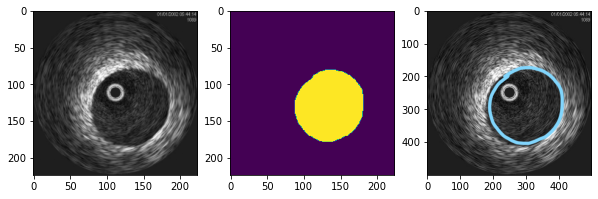

In [9]:
(img,patch_mask,annotation)=dataset['test'][1] 
fig, ax = plt.subplots(1,3, figsize=(10,4)) 

ax[0].imshow(np.moveaxis(img.numpy(),0,-1)) 
ax[1].imshow(patch_mask)
ax[2].imshow(annotation)

In [10]:
def mask_color_img(img, mask, color=[255, 255, 0], alpha=0.001):
    '''
    img: cv2 image
    mask: bool or np.where
    color: BGR triplet [_, _, _]. Default: [0, 200, 200]
    alpha: float [0, 1]. 

    Ref: http://www.pyimagesearch.com/2016/03/07/transparent-overlays-with-opencv/
    '''
    mask = mask.astype(bool)
    out = img.copy()
    img_layer = img.copy()
    img_layer[mask] = color
    out = cv2.addWeighted(img_layer, alpha, out, 1 - alpha, 0, out)
    return(out)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

ave dice coeff: 0.8893410317628994


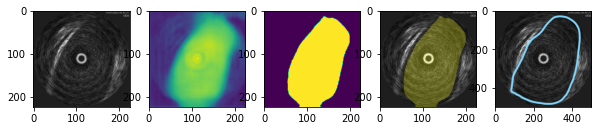

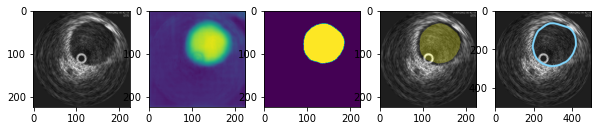

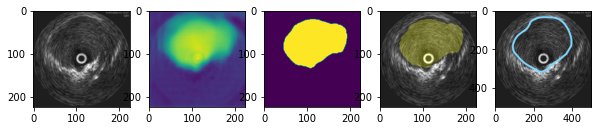

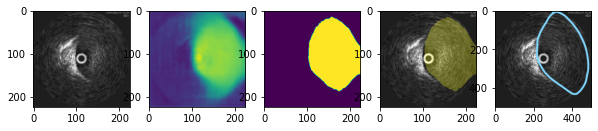

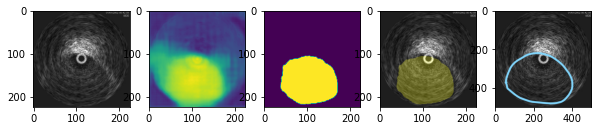

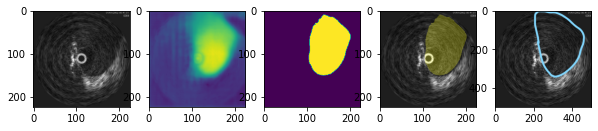

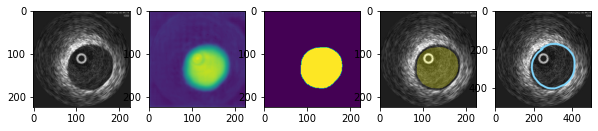

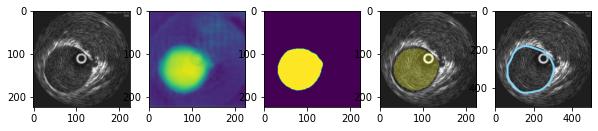

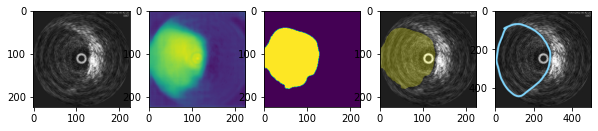

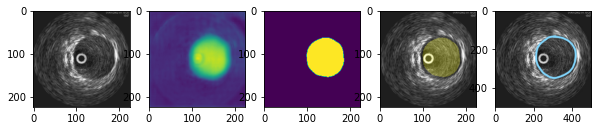

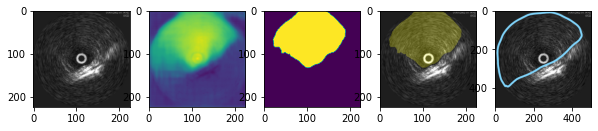

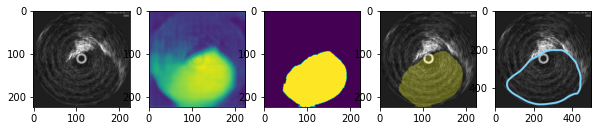

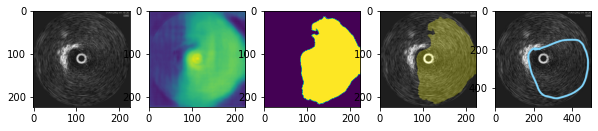

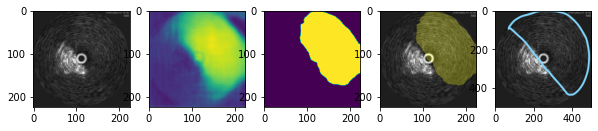

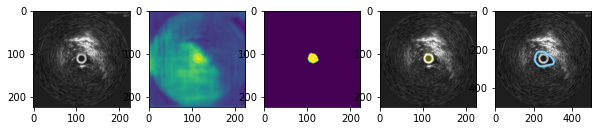

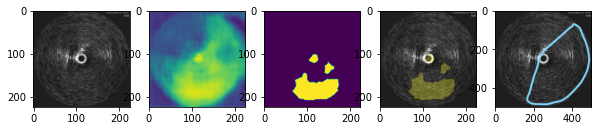

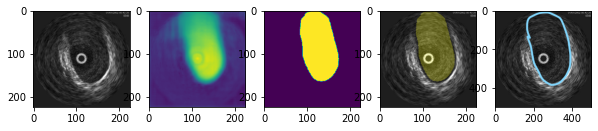

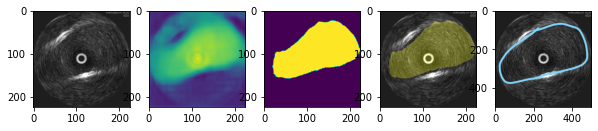

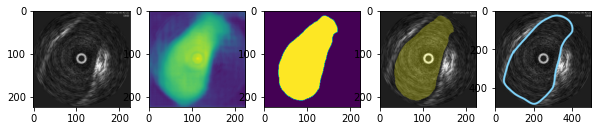

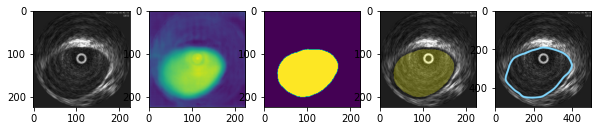

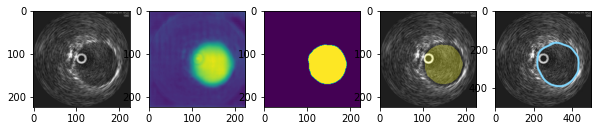

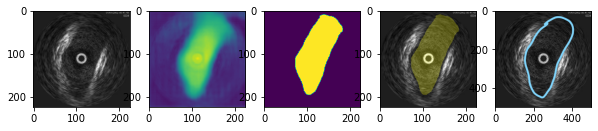

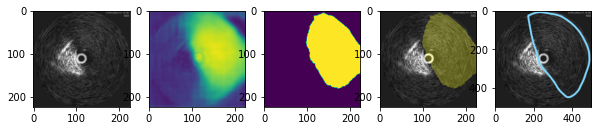

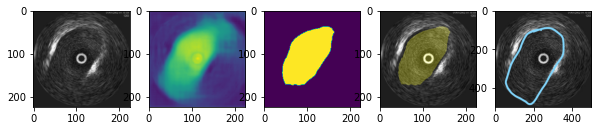

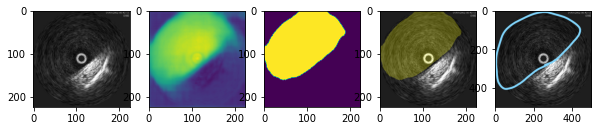

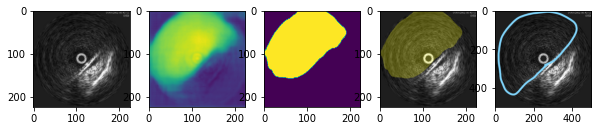

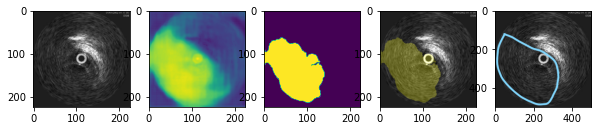

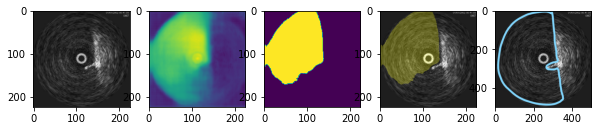

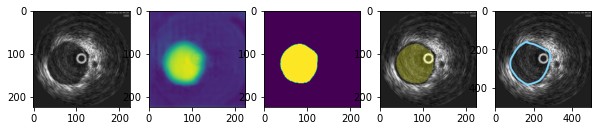

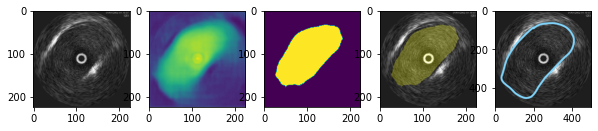

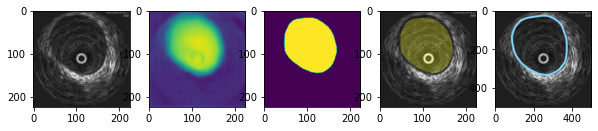

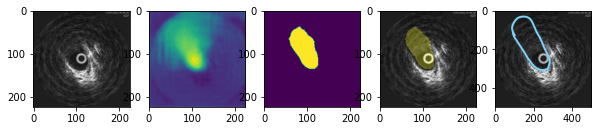

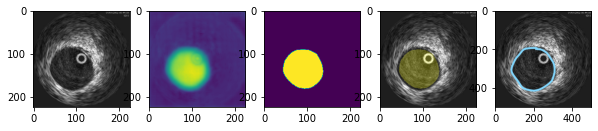

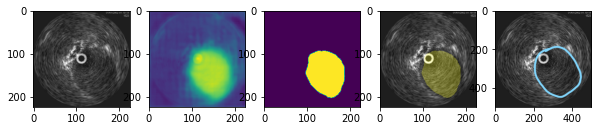

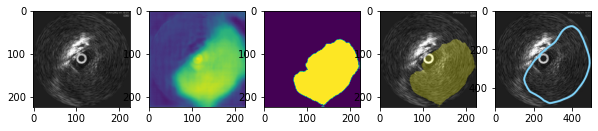

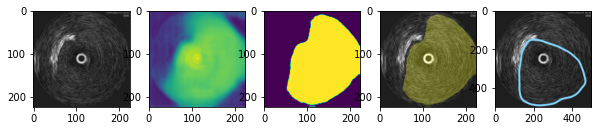

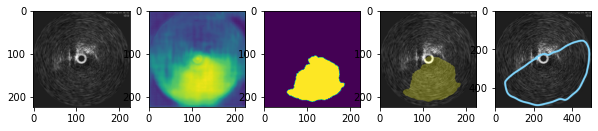

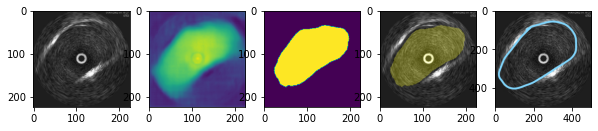

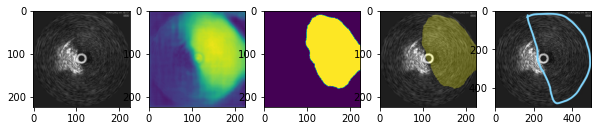

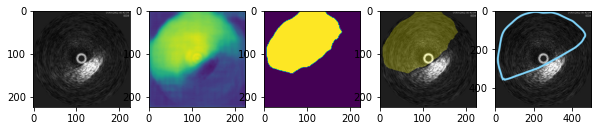

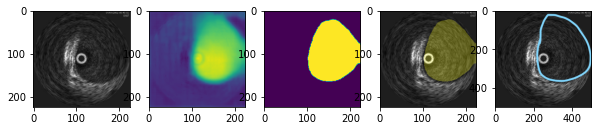

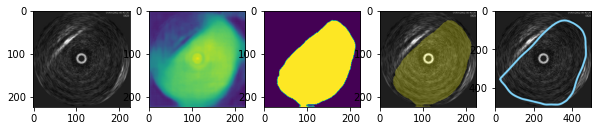

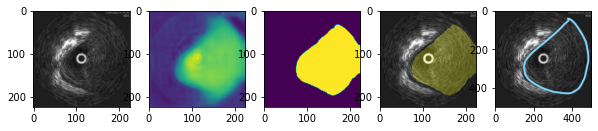

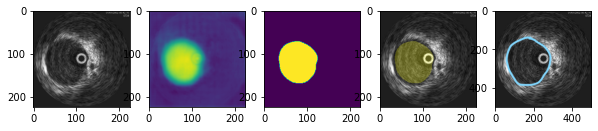

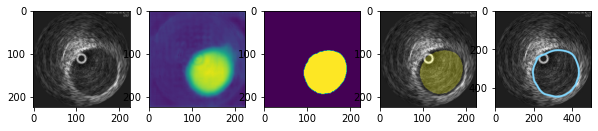

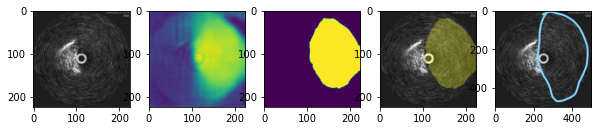

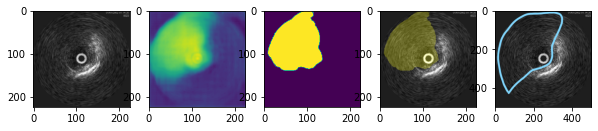

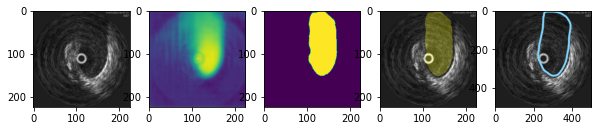

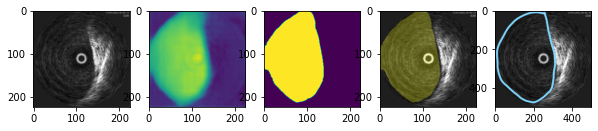

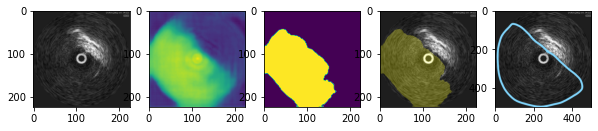

In [11]:
#set the model to evaluation mode, since we're only generating output and not doing any back propogation
model.eval()
dices = []
for ii , (X, y, z) in enumerate(dataLoader["test"]):
    X = X.to(device)  # [NBATCH, 3, H, W]
    output = model(X)  # [NBATCH, 2, H, W]

    output=output.detach().squeeze().cpu().numpy() #get output and pull it to CPU
    output=np.moveaxis(output,0,-1)  #reshape moving last dimension
    
    fig, ax = plt.subplots(1,5, figsize=(10,4))  # 1 row, 2 columns
    dice = dice_coefficient(y.squeeze(), np.argmax(output,axis=2))
    dices.append(dice)
    #print ('dice coefficient of this pair is {}'.format(dice))
    ax[1].imshow(output[:,:,1])
    ax[2].imshow(np.argmax(output,axis=2))
    #ax[1].imshow(y.detach().squeeze().cpu().numpy())
    ax[0].imshow(np.moveaxis(X.detach().squeeze().cpu().numpy(),0,-1))
    masked = mask_color_img(np.moveaxis(X.detach().squeeze().cpu().numpy(),0,-1), np.argmax(output,axis=2))
    ax[3].imshow(masked)
    ax[4].imshow(z.squeeze())
print('ave dice coeff: {}'.format(sum(dices)/len(dices)))